In this Exercise, I will transfer the styles of 2 images to the content image

# Import libs

In [106]:
from PIL import Image

import torchvision.transforms as transforms
from torchvision.models import vgg19 , VGG19_Weights
import torch.optim as optim
import torch.nn as nn
import torch

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data

In [108]:
IMG_SIZE = 256

img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

def img_loader(path):
    img = Image.open(path).convert('RGB')
    img = img_transform(img).unsqueeze(0)
    return img.to(device, dtype=torch.float)

In [109]:
img_style1 = img_loader('style_img.jpg')
img_style2 = img_loader('style_img2.jpg')
img_content = img_loader('content_img.jpg')

# Loss functions

In [110]:
def gram_matrix(x):
    a, b,c,d = x.size()  # a=batch size(=1)
    x = x.view(a * b, c * d)  # resize F_XL into \hat F_XL
    G = torch.mm(x, x.t()) # compute the gram product
    return G.div(a * b * c * d)  # we 'normalize' the values by dividing by the number of element in the feature maps

content_weight = 1
style_weight = 1e6

content_loss = nn.MSELoss()
style_loss = nn.MSELoss()

# Model

In [111]:
backbone = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
backbone.to(device)

for param in backbone.parameters():
    param.requires_grad = False

# Features extract

In [112]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
        self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

normalization = Normalization().to(device)

C:\Users\admin\AppData\Local\Temp\ipykernel_14576\1740699474.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
C:\Users\admin\AppData\Local\Temp\ipykernel_14576\1740699474.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)


In [113]:
content_layer = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_features(model, img):
    layers = {
        '0': 'conv_1',
        '5': 'conv_2',
        '10': 'conv_3',
        '19': 'conv_4',
        '28': 'conv_5'
    }
    features = {}
    x = img
    x = normalization(x)
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Style extract

In [114]:
def get_dual_styles(style_features1, style_features2, style_layers):
    final_style_features = {}
    for layer in style_layers:
        sf1 = style_features1[layer]
        sf2 = style_features2[layer]
        sf1_size = int(sf1.size()[1]/4)
        final_style_features[layer] = torch.cat([
            sf1[:, :sf1_size, :, :],
            sf2[:, sf1_size:, :, :],
        ], dim=1)
    return final_style_features

In [115]:
content_features = get_features(backbone, img_content)
style_features1 = get_features(backbone, img_style1)
style_features2 = get_features(backbone, img_style2)
final_style_features = get_dual_styles(style_features1, style_features2, style_layers)

# Training

In [116]:
target_img = img_content.clone().requires_grad_(True).to(device)
optimizer = optim.Adam([target_img], lr=0.02)

In [117]:
def style_transfer(model, optimizer, target_img, content_features, style_features, content_weight, style_weight):
    optimizer.zero_grad()
    with torch.no_grad():
        target_img.clamp_(0 , 1)
    target_features = get_features(model, target_img)
    content_loss_value = content_loss(target_features[content_layer[0]], content_features[content_layer[0]])

    style_loss_value = 0
    for layer in style_layers:
        target_gram = gram_matrix(target_features[layer])
        style_gram = gram_matrix(style_features[layer])
        style_loss_value += style_loss(target_gram, style_gram)

    total_loss = content_weight * content_loss_value + style_weight * style_loss_value
    total_loss.backward(retain_graph=True)
    optimizer.step()
    return total_loss, content_loss_value, style_loss_value

In [118]:
EPOCHS = 500

for i in range(EPOCHS):
    total_loss, content_loss_value, style_loss_value = style_transfer(backbone, optimizer, target_img, content_features, final_style_features, content_weight, style_weight)
    if i % 100 == 99:
        print(f"Epoch {i}/{EPOCHS}, Total Loss: {total_loss.item()}, Content Loss: {content_loss_value.item()}, Style Loss: {style_loss_value.item()}")
    with torch.no_grad():
        target_img.clamp_(0, 1)

Epoch 99/500, Total Loss: 101.04588317871094, Content Loss: 22.90792465209961, Style Loss: 7.813796401023865e-05
Epoch 199/500, Total Loss: 94.9993896484375, Content Loss: 22.95845603942871, Style Loss: 7.204092980828136e-05
Epoch 299/500, Total Loss: 92.71334838867188, Content Loss: 23.143070220947266, Style Loss: 6.957027653697878e-05
Epoch 399/500, Total Loss: 91.28536224365234, Content Loss: 23.146883010864258, Style Loss: 6.813848449382931e-05
Epoch 499/500, Total Loss: 90.69986724853516, Content Loss: 22.698354721069336, Style Loss: 6.800150731578469e-05


# See the result

In [119]:
# Get the final image
final_img = target_img.clone().cpu().detach()
final_img = final_img.squeeze(0).permute(1, 2, 0).numpy()
final_img = (final_img * 255).astype('uint8')
final_img = Image.fromarray(final_img)
final_img.save('Ex1_output_image.jpg')

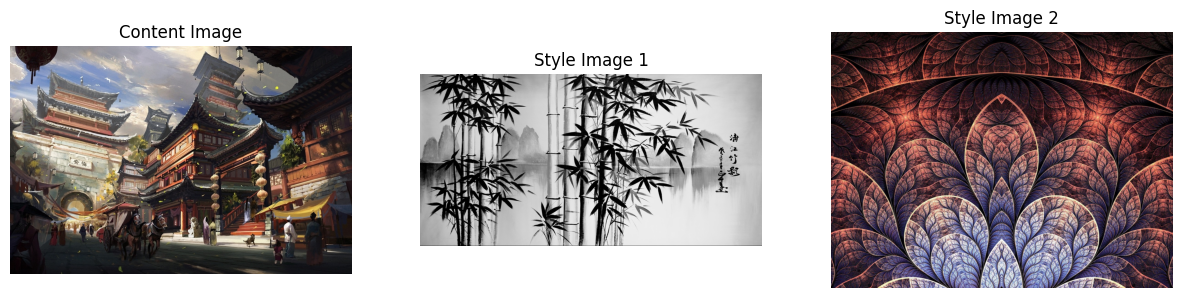

(np.float64(-0.5), np.float64(1508.5), np.float64(1007.5), np.float64(-0.5))

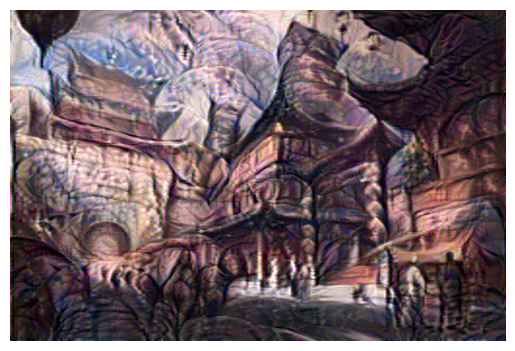

In [120]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
content = Image.open('content_img.jpg')
style1 = Image.open('style_img.jpg')
style2 = Image.open('style_img2.jpg')
ax[0].imshow(content)
ax[0].set_title('Content Image')
ax[0].axis('off')
ax[1].imshow(style1)
ax[1].set_title('Style Image 1')
ax[1].axis('off')
ax[2].imshow(style2)
ax[2].set_title('Style Image 2')
ax[2].axis('off')
plt.show()

final = final_img.resize((content.size[0], content.size[1]))
plt.imshow(final)
plt.axis('off')